In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelleme için gerekli kütüphaneler:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, brier_score_loss 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression  
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [4]:
file_name = "C:/Users/ulasdeneme/Downloads/CDC_Wastewater_Data_for_Influenza_A.csv"

df = pd.read_csv(file_name, low_memory=False)

print("Veri seti yüklendi. İlk 5 satır:")
print(df.head())

Veri seti yüklendi. İlk 5 satır:
   sewershed_id wwtp_jurisdiction county_fips counties_served  \
0          2407                al       01125      Tuscaloosa   
1          2167                wi       55127        Walworth   
2           488                il       17167        Sangamon   
3           434                il       17043         Du Page   
4            97                ca       06013    Contra Costa   

   population_served                         sample_id sample_collect_date  \
0              12278  05a02bd4d68420ea7e9c030e8ce7fd08          2025-06-08   
1              30000  09e73eabdeca41f149d08ede0d92bbf1          2024-08-12   
2             102000  0b751586bf4ed642b7d73402c69d58a1          2024-05-16   
3              59805  0e3eb697c96f9645c691e10631317c7c          2025-01-28   
4             487300  176c33eaf7e144d6d9e2b5a9870b08bd          2025-02-05   

                     sample_type   sample_matrix sample_location  ...  \
0  24-hr time-weighted composite  

In [5]:
# --- 3. BLOK: VERİ TEMİZLİĞİ VE ÖZELLİK MÜHENDİSLİĞİ (TÜM HATALAR GİDERİLDİ) ---

print("--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---")

# --- BİRİNCİ BÖLÜM: TEMİZLİK VE MÜHENDİSLİK ---

# 1. ZAMAN BAZLI ÖZELLİKLERİ ÇIKARMA (collection_month hatasını çözer)
df['sample_collect_date'] = pd.to_datetime(df['sample_collect_date'], errors='coerce')
df['collection_month'] = df['sample_collect_date'].dt.month
df['collection_week'] = df['sample_collect_date'].dt.isocalendar().week.fillna(-1).astype(int)
df['collection_dayofweek'] = df['sample_collect_date'].dt.dayofweek

# 2. EKSİK VERİ GİDERME
df['flow_rate_missing'] = df['flow_rate'].isnull().astype(int)
flow_median = df['flow_rate'].median()
df['flow_rate'] = df['flow_rate'].fillna(flow_median)

if 'pcr_target_flowpop_lin' in df.columns:
    df['pcr_target_flowpop_lin'] = df['pcr_target_flowpop_lin'].fillna(df['pcr_target_flowpop_lin'].median())
    df['flowpop_lin_missing'] = df['pcr_target_flowpop_lin'].isnull().astype(int)
else:
    df['flowpop_lin_missing'] = 0 
    print("UYARI: 'pcr_target_flowpop_lin' sütunu bulunamadı, 'flowpop_lin_missing' 0 olarak ayarlandı.")

# 3. LOGARİTMİK DÖNÜŞTÜRME (log_pcr_target_conc hatasını çözer)
df['log_population_served'] = np.log1p(df['population_served'])
df['log_flow_rate'] = np.log1p(df['flow_rate'])

# Hedef değişkeni oluşturma
df['influenza_a_detected'] = (df['pcr_target_avg_conc'] > 0).astype(int)
df['log_pcr_target_conc'] = np.log1p(df['pcr_target_avg_conc'])

# 4. LAG ÖZELLİKLERİ (wwtp_jurisdiction yazım hatası düzeltildi)
print("Adım: Zaman serisi Lag özellikleri oluşturuluyor...")
df = df.sort_values(by=['wwtp_jurisdiction', 'sample_collect_date'])

# HATA BURADAYDI, DÜZELTİLDİ:
df['log_conc_lag1'] = df.groupby('wwtp_jurisdiction')['log_pcr_target_conc'].shift(1)
df['log_conc_lag2'] = df.groupby('wwtp_jurisdiction')['log_pcr_target_conc'].shift(2)

df['log_conc_lag1'] = df['log_conc_lag1'].fillna(0)
df['log_conc_lag2'] = df['log_conc_lag2'].fillna(0)

# 5. POPULATION GROUP (population_group hatasını çözer)
bins = [0, 20000, 50000, 200000, np.inf]
labels = ['Small', 'Medium', 'Large', 'Very Large']
df['population_group'] = pd.cut(df['population_served'], bins=bins, labels=labels, right=False)

# 6. HEDEF KODLAMA (Target Encoding)
print("Adım: Hedef Kodlama (Target Encoding) oluşturuluyor...")
target_map = df.groupby('wwtp_jurisdiction')['influenza_a_detected'].mean()
df['jurisdiction_target_mean'] = df['wwtp_jurisdiction'].map(target_map)
df['jurisdiction_target_mean'] = df['jurisdiction_target_mean'].fillna(0.5)

# 7. GEREKSİZ SÜTUNLARI ÇIKARMA
columns_to_drop = [
    'inhibition_adjust', 'sample_id', 'date_updated', 'rec_eff_target_name', 
    'rec_eff_spike_matrix', 'rec_eff_spike_conc', 'hum_frac_mic_unit', 
    'pcr_target_mic_lin', 'hum_frac_mic_conc', 'hum_frac_target_mic',
    'ntc_amplify', 
    'pcr_target' 
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Kalan eksiklikler
if 'pasteurized' in df.columns:
    df['pasteurized'] = df['pasteurized'].fillna(df['pasteurized'].mode()[0])
df['counties_served'] = df['counties_served'].fillna(df['counties_served'].mode()[0])
df['lod_sewage'] = df['lod_sewage'].fillna(df['lod_sewage'].median())

if 'pcr_gene_target_agg' in df.columns:
    df['pcr_gene_target_agg'] = df['pcr_gene_target_agg'].fillna(df['pcr_gene_target_agg'].mode()[0])

if 'rec_eff_percent' in df.columns:
    df['rec_eff_percent'] = np.clip(df['rec_eff_percent'], a_min=None, a_max=100)
else:
    df['rec_eff_percent'] = 0 

# Mükerrer kayıtları sil
df.drop_duplicates(inplace=True)

# 8. ENCODING
print("Adım: 'population_group_encoded' sütunu ekleniyor...")
pop_kategorileri = pd.CategoricalDtype(
    categories=['Small', 'Medium', 'Large', 'Very Large'],
    ordered=True
)
df['population_group'] = df['population_group'].astype(pop_kategorileri)
df['population_group_encoded'] = df['population_group'].cat.codes

# 9. ETKİLEŞİM ÖZELLİKLERİ
print("Adım: Etkileşim Özellikleri oluşturuluyor...")
df['pop_x_flow'] = df['log_population_served'] * df['log_flow_rate']
df['pop_x_rec_eff'] = df['log_population_served'] * df['rec_eff_percent']

print("--- Veri Temizliği ve Özellik Mühendisliği Tamamlandı ---")

--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---
Adım: Zaman serisi Lag özellikleri oluşturuluyor...
Adım: Hedef Kodlama (Target Encoding) oluşturuluyor...
Adım: 'population_group_encoded' sütunu ekleniyor...
Adım: Etkileşim Özellikleri oluşturuluyor...
--- Veri Temizliği ve Özellik Mühendisliği Tamamlandı ---



--- 1. Sınıflandırma Analizi: Sınıf Dağılımı ---
Sınıf Sayısı: 2
Sınıf Dağılımı (Label Counts):
influenza_a_detected
0    123159
1     89242
Name: count, dtype: int64


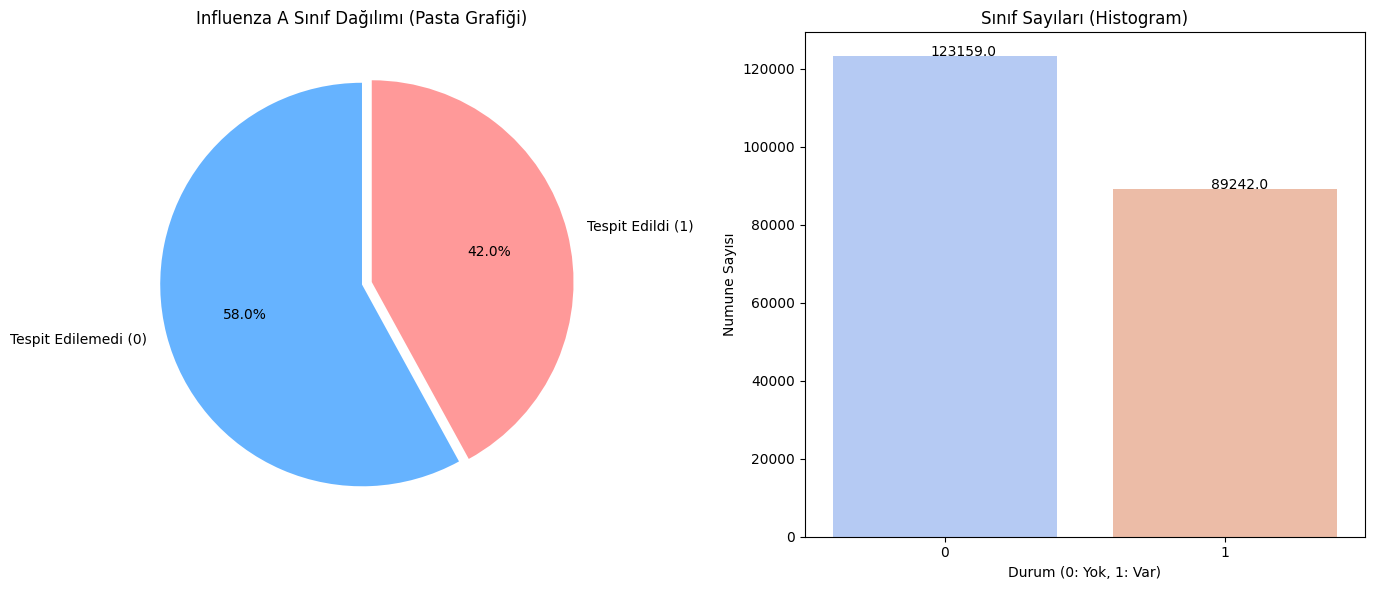


--- 2. Regresyon/Zaman Serisi Analizi: Veri Geçmişi ---
Veri Setindeki En Eski Tarih: 2021-09-15
Veri Setindeki En Yeni Tarih: 2025-09-23
Toplam Veri Geçmişi: 1469 gün
Toplam Numune Sayısı: 212401


In [7]:
# --- EK ANALİZ: SINIF DAĞILIMI VE ZAMAN BİLGİSİ ---

print("\n--- 1. Sınıflandırma Analizi: Sınıf Dağılımı ---")
# Hedef değişken: influenza_a_detected
class_counts = df['influenza_a_detected'].value_counts()
print(f"Sınıf Sayısı: {len(class_counts)}")
print("Sınıf Dağılımı (Label Counts):")
print(class_counts)

# Görselleştirme (Pie Chart ve Count Plot yan yana)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Pasta Grafiği (Pie Chart)
ax[0].pie(class_counts, labels=['Tespit Edilemedi (0)', 'Tespit Edildi (1)'], 
          autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'], explode=(0, 0.05))
ax[0].set_title('Influenza A Sınıf Dağılımı (Pasta Grafiği)')

# 2. Çubuk Grafiği (Count Plot)
sns.countplot(x='influenza_a_detected', hue='influenza_a_detected', legend=False, data=df, palette='coolwarm', ax=ax[1])
ax[1].set_title('Sınıf Sayıları (Histogram)')
ax[1].set_xlabel('Durum (0: Yok, 1: Var)')
ax[1].set_ylabel('Numune Sayısı')
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 5))

plt.tight_layout()
plt.show()

print("\n--- 2. Regresyon/Zaman Serisi Analizi: Veri Geçmişi ---")
# Tarih aralığı hesaplama
min_date = df['sample_collect_date'].min()
max_date = df['sample_collect_date'].max()
duration = max_date - min_date

print(f"Veri Setindeki En Eski Tarih: {min_date.date()}")
print(f"Veri Setindeki En Yeni Tarih: {max_date.date()}")
print(f"Toplam Veri Geçmişi: {duration.days} gün")
print(f"Toplam Numune Sayısı: {df.shape[0]}")

1. Grafik Çiziliyor...


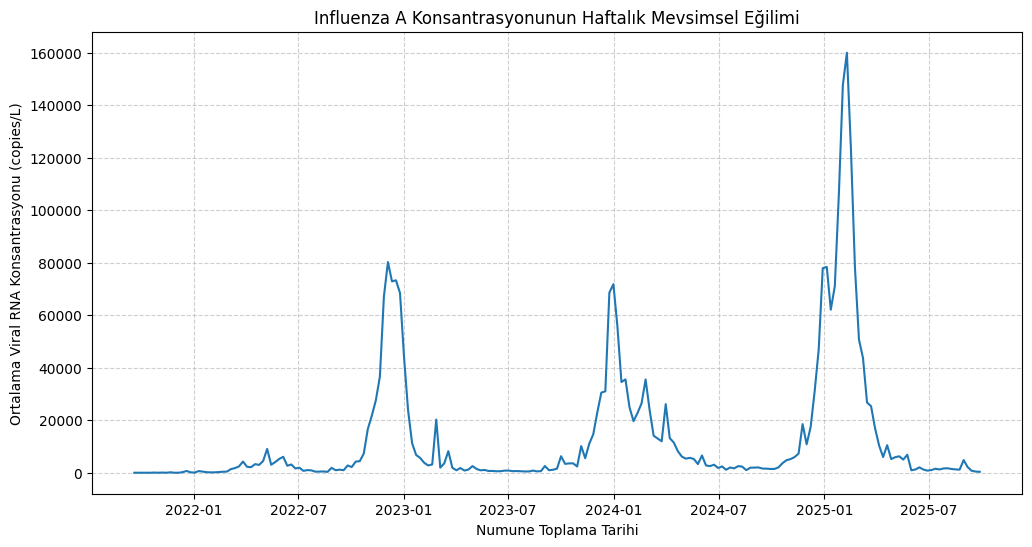

In [8]:
# 1. Standart Mevsimsel Eğilim (Zaman)
print("1. Grafik Çiziliyor...")
plt.figure(figsize=(12, 6))

# Verinin kopyasını al ve boş olanları at
weekly_avg_data = df.dropna(subset=['sample_collect_date', 'pcr_target_avg_conc']).copy()

# --- HATA ÇÖZÜMÜ BURADA ---
# Tarih sütununu zorla datetime formatına çeviriyoruz:
weekly_avg_data['sample_collect_date'] = pd.to_datetime(weekly_avg_data['sample_collect_date'], errors='coerce')

if not weekly_avg_data.empty:
    # Şimdi set_index yapıp resample yapabiliriz
    weekly_avg = weekly_avg_data.set_index('sample_collect_date')['pcr_target_avg_conc'].resample('W').mean().reset_index()
    
    sns.lineplot(data=weekly_avg, x='sample_collect_date', y='pcr_target_avg_conc')
    plt.title('Influenza A Konsantrasyonunun Haftalık Mevsimsel Eğilimi')
    plt.xlabel('Numune Toplama Tarihi')
    plt.ylabel('Ortalama Viral RNA Konsantrasyonu (copies/L)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Grafik çizilemedi: Tarih veya Konsantrasyon verisi boş.")

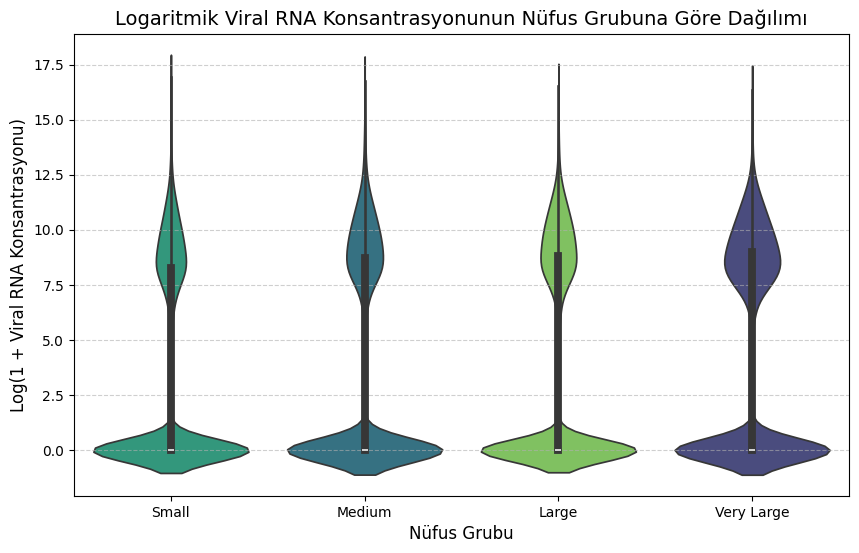

In [9]:
# 2. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df['population_group'].astype(str), y='log_pcr_target_conc', data=df,
    order=['Small', 'Medium', 'Large', 'Very Large'], palette='viridis',
    hue=df['population_group'].astype(str), legend=False
)
plt.title('Logaritmik Viral RNA Konsantrasyonunun Nüfus Grubuna Göre Dağılımı', fontsize=14)
plt.xlabel('Nüfus Grubu', fontsize=12)
plt.ylabel('Log(1 + Viral RNA Konsantrasyonu)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show() 

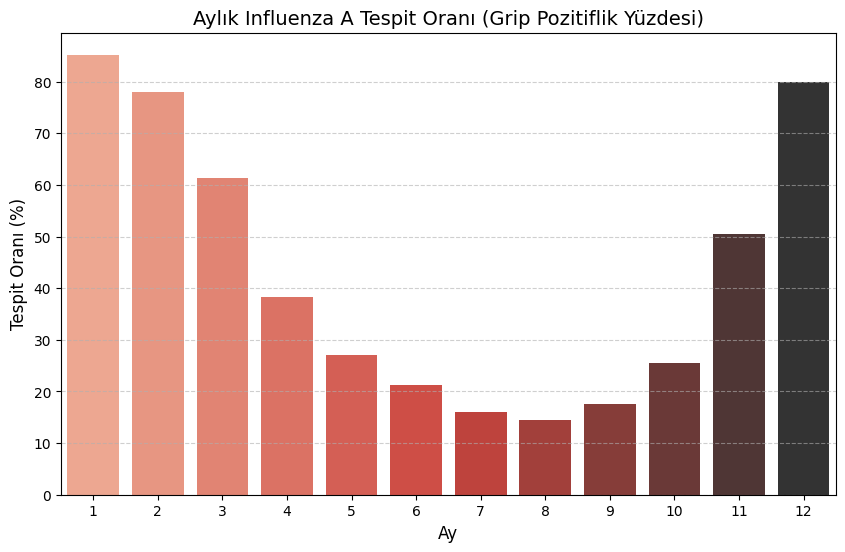

In [10]:
# 3. Aylık Pozitiflik Oranı
monthly_data = df.dropna(subset=['collection_month'])
if not monthly_data.empty:
    monthly_total = monthly_data.groupby('collection_month').size().reset_index(name='total_samples')
    monthly_detected = monthly_data[monthly_data['influenza_a_detected'] == 1].groupby('collection_month').size().reset_index(name='detected_samples')
    monthly_detection_rate = pd.merge(monthly_total, monthly_detected, on='collection_month', how='left')
    monthly_detection_rate['detected_samples'] = monthly_detection_rate['detected_samples'].fillna(0)
    monthly_detection_rate['detection_rate'] = (monthly_detection_rate['detected_samples'] / monthly_total['total_samples']) * 100

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='collection_month', y='detection_rate', data=monthly_detection_rate,
        palette='Reds_d', hue='collection_month', legend=False
    )
    plt.title('Aylık Influenza A Tespit Oranı (Grip Pozitiflik Yüzdesi)', fontsize=14)
    plt.xlabel('Ay', fontsize=12)
    plt.ylabel('Tespit Oranı (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show() 

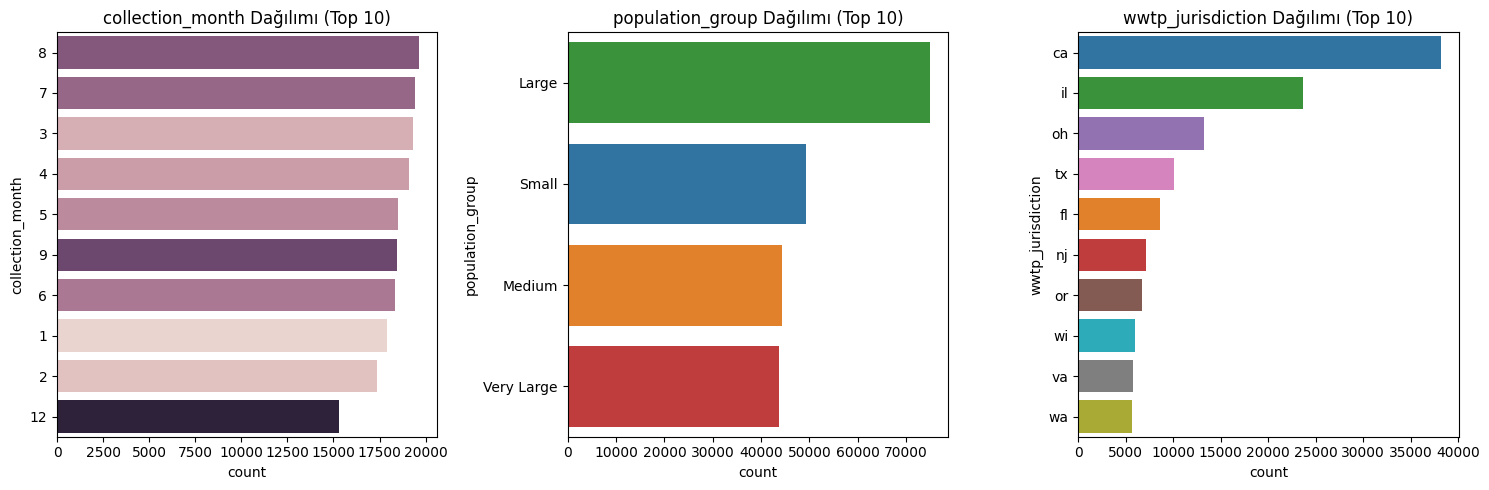

In [11]:
# 4. Kategorik Dağılımlar
categorical_cols_for_plot = ['collection_month', 'population_group', 'wwtp_jurisdiction']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols_for_plot):
    if col in df.columns:
        plt.subplot(1, 3, i + 1)
        plot_data = df[col].dropna()
        if not plot_data.empty:
            top_10_categories = plot_data.value_counts().index[:10]
            plot_df = df[df[col].isin(top_10_categories)]
            sns.countplot(data=plot_df, y=col, order=top_10_categories, hue=col, legend=False)
        plt.title(f'{col} Dağılımı (Top 10)')
plt.tight_layout()
plt.show() 

In [12]:
# --- ÜÇÜNCÜ BÖLÜM: KAYDETME ---
output_file_name = "ulasfeatureseletion.csv"
df.to_csv(output_file_name, index=False)
print(f"\nTemizlenmiş ve (YENİ V2 ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: {output_file_name}")


Temizlenmiş ve (YENİ V2 ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: ulasfeatureseletion.csv


In [13]:
# --- DÖRDÜNCÜ BÖLÜM: ALGORİTMA SEÇİMİ VE MODEL EĞİTİMİ ---

# 1. ÖZELLİK VE HEDEF BELİRLEME
features = [
    'collection_month', 'collection_week', 'collection_dayofweek',
    'log_population_served', 'log_flow_rate', 'rec_eff_percent',
    'flow_rate_missing', 'flowpop_lin_missing',
    'population_group_encoded', 'log_conc_lag1', 'log_conc_lag2',
    'jurisdiction_target_mean', 'pop_x_flow', 'pop_x_rec_eff'
]

if 'rec_eff_percent' not in df.columns:
    features_to_remove = ['rec_eff_percent', 'pop_x_rec_eff']
    features = [f for f in features if f not in features_to_remove]

df_model = df.dropna(subset=features + ['influenza_a_detected'])
X = df_model[features]
y = df_model['influenza_a_detected']

print(f"\nModelin Kullanacağı Toplam Özellik Sayısı: {X.shape[1]}")
print(f"Model Eğitimi İçin Kullanılan Toplam Satır Sayısı: {X.shape[0]}")

# 2. VERİYİ BÖLME
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. VERİ ÖLÇEKLEME (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Modelin Kullanacağı Toplam Özellik Sayısı: 14
Model Eğitimi İçin Kullanılan Toplam Satır Sayısı: 212401


In [14]:
# --- PCA (TEMEL BİLEŞEN ANALİZİ) ---
print("\n--- PCA ANALİZİNE BAŞLANIYOR ---")
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Orijinal özellik sayısı: {X_train_scaled.shape[1]}")
print(f"PCA sonrası özellik sayısı (%95 varyans): {X_train_pca.shape[1]}")
# --- PCA BÖLÜMÜ SONU ---


--- PCA ANALİZİNE BAŞLANIYOR ---
Orijinal özellik sayısı: 14
PCA sonrası özellik sayısı (%95 varyans): 8


In [15]:
# --- GELİŞMİŞ HYPERPARAMETER TUNING (Sadece GB ve ExtraTrees) ---
from sklearn.model_selection import GridSearchCV

print("\n--- Çoklu Model Hyperparameter Tuning Başlıyor ---")
print("Sadece Gradient Boosting ve Extra Trees taranıyor. Daha hızlı ve güvenli...\n")

# 1. Ayarlanacak Modeller ve Parametre Izgaraları
model_params = {
    # GRADIENT BOOSTING İÇİN AYARLAR
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],       
            'learning_rate': [0.01, 0.1],     
            'max_depth': [3, 5]               
        }
    },
    
    # EXTRA TREES İÇİN AYARLAR
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'criterion': ['gini', 'entropy'], 
            'max_depth': [None, 10]           
        }
    }
    # MLP KISMI SİLİNDİ (Hafıza Tasarrufu İçin)
}

# 2. Döngü ile Hepsini Ara
best_estimators = {} # En iyi modelleri burada saklayacağız

for model_name, mp in model_params.items():
    print(f"--> {model_name} taranıyor...")
    
    # GÜVENLİ AYAR: n_jobs=1 yaptık (Bilgisayar donmasın diye)
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, n_jobs=1, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    
    # Sonuçları Kaydetme ve Yazdırma
    best_estimators[model_name] = clf.best_estimator_
    print(f"    En İyi Parametreler: {clf.best_params_}")
    print(f"    En İyi Skor: %{clf.best_score_*100:.2f}\n")

print("--- Tuning Tamamlandı! En iyi modeller bulundu. ---")


--- Çoklu Model Hyperparameter Tuning Başlıyor ---
Sadece Gradient Boosting ve Extra Trees taranıyor. Daha hızlı ve güvenli...

--> GradientBoosting taranıyor...
    En İyi Parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    En İyi Skor: %81.54

--> ExtraTrees taranıyor...
    En İyi Parametreler: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}
    En İyi Skor: %80.27

--- Tuning Tamamlandı! En iyi modeller bulundu. ---


In [16]:
# --- 8. BLOK (GÜNCELLENMİŞ: GÖRSELDEKİ GİBİ ÇİFT SATIRLI TABLO) ---
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, brier_score_loss

print("\n--- DETAYLI MODEL RAPORLAMA BAŞLIYOR (Class-Based Format) ---")

# Modelleri tanımla (Sizin kodunuzdaki liste)
# Not: Hata almamak için LinearRegression n_jobs=1 yapıldı.
models = {
    'GradientBoosting (ensemble) (Orijinal)': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'LinearRegression (base) (Orijinal)': LinearRegression(n_jobs=1),
    'MLPClassifier (advanced) (Orijinal)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    'ExtraTrees (advanced) (Orijinal)': ExtraTreesClassifier(n_estimators=200, random_state=42),
    
    'GradientBoosting (ensemble) (PCA)': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'LinearRegression (base) (PCA)': LinearRegression(n_jobs=1),
    'MLPClassifier (advanced) (PCA)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    'ExtraTrees (advanced) (PCA)': ExtraTreesClassifier(n_estimators=200, random_state=42)
}

# Veri setlerini tanımla
data_sets = {
    'GradientBoosting (ensemble) (Orijinal)': (X_train_scaled, X_test_scaled),
    'LinearRegression (base) (Orijinal)': (X_train_scaled, X_test_scaled),
    'MLPClassifier (advanced) (Orijinal)': (X_train_scaled, X_test_scaled),
    'ExtraTrees (advanced) (Orijinal)': (X_train_scaled, X_test_scaled),

    'GradientBoosting (ensemble) (PCA)': (X_train_pca, X_test_pca),
    'LinearRegression (base) (PCA)': (X_train_pca, X_test_pca),
    'MLPClassifier (advanced) (PCA)': (X_train_pca, X_test_pca),
    'ExtraTrees (advanced) (PCA)': (X_train_pca, X_test_pca)
}

# Sonuçları saklamak için yeni liste
detailed_results = []

for model_name, model in models.items():
    print(f"--> {model_name} Analiz Ediliyor...")
    X_train_data, X_test_data = data_sets[model_name]
    
    # 1. Model Eğitimi
    model.fit(X_train_data, y_train)
    
    # 2. Tahminler
    if "LinearRegression" in model_name:
        y_pred_continuous = model.predict(X_test_data)
        y_pred_binary = (y_pred_continuous > 0.5).astype(int)
        y_pred_proba_positive = np.clip(y_pred_continuous, 0, 1)
    else:
        y_pred_binary = model.predict(X_test_data)
        y_pred_proba_positive = model.predict_proba(X_test_data)[:, 1]
    
    # 3. Genel Metrikler (Tüm sınıflar için ortak olanlar)
    acc = accuracy_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred_proba_positive)
    pr_auc = average_precision_score(y_test, y_pred_proba_positive) # Görselde vardı, ekledim
    brier = brier_score_loss(y_test, y_pred_proba_positive) # IBS
    
    # 4. Sınıf Bazlı Metrikler (F1 Score'u ayırmak için)
    # output_dict=True diyerek raporu bir sözlük gibi alıyoruz
    report = classification_report(y_test, y_pred_binary, output_dict=True)
    
    # --- SATIR 1: GRİP YOK (0) İÇİN KAYIT ---
    detailed_results.append({
        'Model': model_name,
        'Class': 'Grip Yok (0)',
        'F1 Score': report['0']['f1-score'],  # Sadece 0 sınıfının F1'i
        'ROC AUC': roc_auc,                   # Genel
        'PR AUC': pr_auc,                     # Genel
        'Accuracy': acc,                      # Genel
        'IBS (Brier)': brier                  # Genel
    })
    
    # --- SATIR 2: GRİP VAR (1) İÇİN KAYIT ---
    detailed_results.append({
        'Model': model_name,
        'Class': 'Grip Var (1)',              # <-- ÖNEMLİ: Pozitif sınıf
        'F1 Score': report['1']['f1-score'],  # Sadece 1 sınıfının F1'i
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'Accuracy': acc,
        'IBS (Brier)': brier
    })

# Tabloyu Oluşturma
final_df = pd.DataFrame(detailed_results)

# Sütun sırasını görseldeki gibi ayarlama
column_order = ['Model', 'Class', 'F1 Score', 'ROC AUC', 'PR AUC', 'Accuracy', 'IBS (Brier)']
final_df = final_df[column_order]

print("\n--- DETAYLI SONUÇ TABLOSU (İstediğiniz Format) ---")
# Tabloyu tam göstermek için ayarlar
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Tabloyu yazdır
print(final_df)


--- DETAYLI MODEL RAPORLAMA BAŞLIYOR (Class-Based Format) ---
--> GradientBoosting (ensemble) (Orijinal) Analiz Ediliyor...
--> LinearRegression (base) (Orijinal) Analiz Ediliyor...
--> MLPClassifier (advanced) (Orijinal) Analiz Ediliyor...
--> ExtraTrees (advanced) (Orijinal) Analiz Ediliyor...
--> GradientBoosting (ensemble) (PCA) Analiz Ediliyor...
--> LinearRegression (base) (PCA) Analiz Ediliyor...
--> MLPClassifier (advanced) (PCA) Analiz Ediliyor...
--> ExtraTrees (advanced) (PCA) Analiz Ediliyor...

--- DETAYLI SONUÇ TABLOSU (İstediğiniz Format) ---
                                     Model         Class  F1 Score   ROC AUC    PR AUC  Accuracy  IBS (Brier)
0   GradientBoosting (ensemble) (Orijinal)  Grip Yok (0)  0.842383  0.875612  0.858563  0.808597     0.136405
1   GradientBoosting (ensemble) (Orijinal)  Grip Var (1)  0.756375  0.875612  0.858563  0.808597     0.136405
2       LinearRegression (base) (Orijinal)  Grip Yok (0)  0.817099  0.832796  0.805157  0.776300     0.16


--- Stratified K-Fold Cross Validation Başlıyor ---
Veri seti 5 parçaya bölünüyor. Her parça sırasıyla test seti olacak.
Bu yöntem, sınıf dengesizliğini koruyarak (Stratified) daha güvenilir sonuç verir.

Gradient Boosting -> 5 Katlı CV Skorları: [0.80234816 0.80346634 0.79805202 0.80111229 0.79937618]
Gradient Boosting -> Ortalama Doğruluk: %80.09 (+/- %0.20)

Extra Trees -> 5 Katlı CV Skorları: [0.80502589 0.80708569 0.80075918 0.80164195 0.80343691]
Extra Trees -> Ortalama Doğruluk: %80.36 (+/- %0.23)

MLP Classifier -> 5 Katlı CV Skorları: [0.80643832 0.80614407 0.80458451 0.80217161 0.8017008 ]
MLP Classifier -> Ortalama Doğruluk: %80.42 (+/- %0.20)



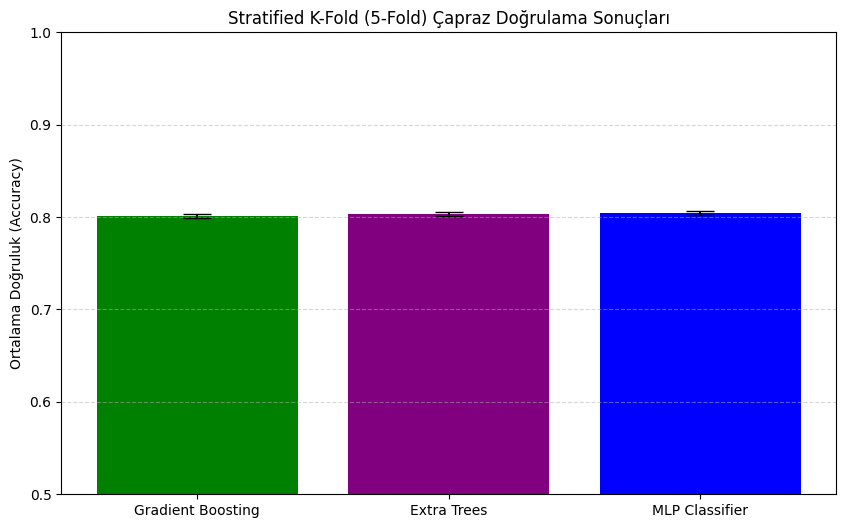

StratifiedKFold, veri setindeki sınıf oranlarını (Grip Var/Yok) her katmanda korur.


In [17]:
# --- STRATIFIED K-FOLD CROSS VALIDATION (PROFESYONEL DEĞERLENDİRME) ---
from sklearn.model_selection import StratifiedKFold, cross_val_score


print("\n--- Stratified K-Fold Cross Validation Başlıyor ---")
print("Veri seti 5 parçaya bölünüyor. Her parça sırasıyla test seti olacak.")
print("Bu yöntem, sınıf dengesizliğini koruyarak (Stratified) daha güvenilir sonuç verir.\n")

# StratifiedKFold Tanımlama (5 Katlı)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Değerlendirilecek Modeller (Sınıflandırma Modelleri)
cv_models = {
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Sonuçları Sakla
cv_results = []

for name, model in cv_models.items():
    # cross_val_score, verilen stratejiye (skf) göre modeli 5 kere eğitip test eder
    # scoring='accuracy' veya 'roc_auc' kullanabiliriz
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    
    print(f"{name} -> 5 Katlı CV Skorları: {scores}")
    print(f"{name} -> Ortalama Doğruluk: %{scores.mean()*100:.2f} (+/- %{scores.std()*100:.2f})\n")
    
    cv_results.append({
        'Model': name,
        'Mean Accuracy': scores.mean(),
        'Standard Deviation': scores.std()
    })

# CV Sonuçlarını Görselleştirme
cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(10, 6))
# Hata çubukları (yerr) standart sapmayı gösterir
plt.bar(cv_df['Model'], cv_df['Mean Accuracy'], yerr=cv_df['Standard Deviation'], capsize=10, color=['green', 'purple', 'blue'])
plt.title('Stratified K-Fold (5-Fold) Çapraz Doğrulama Sonuçları')
plt.ylabel('Ortalama Doğruluk (Accuracy)')
plt.ylim(0.5, 1.0) # Skalanın daha iyi görünmesi için
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("StratifiedKFold, veri setindeki sınıf oranlarını (Grip Var/Yok) her katmanda korur.")

In [23]:
# Tablo ismini grafik kodunun anlayacağı hale getiriyoruz
results_df = final_df.copy()

# Şimdi ilk 5 satırı görerek emin olalım
print("Tablo kopyalandı! Grafik çizdirilebilir.")
print(results_df.head())

Tablo kopyalandı! Grafik çizdirilebilir.
                                    Model         Class  F1 Score   ROC AUC    PR AUC  Accuracy  IBS (Brier)
0  GradientBoosting (ensemble) (Orijinal)  Grip Yok (0)  0.842383  0.875612  0.858563  0.808597     0.136405
1  GradientBoosting (ensemble) (Orijinal)  Grip Var (1)  0.756375  0.875612  0.858563  0.808597     0.136405
2      LinearRegression (base) (Orijinal)  Grip Yok (0)  0.817099  0.832796  0.805157  0.776300     0.160535
3      LinearRegression (base) (Orijinal)  Grip Var (1)  0.712074  0.832796  0.805157  0.776300     0.160535
4     MLPClassifier (advanced) (Orijinal)  Grip Yok (0)  0.839598  0.873315  0.854444  0.806125     0.137868


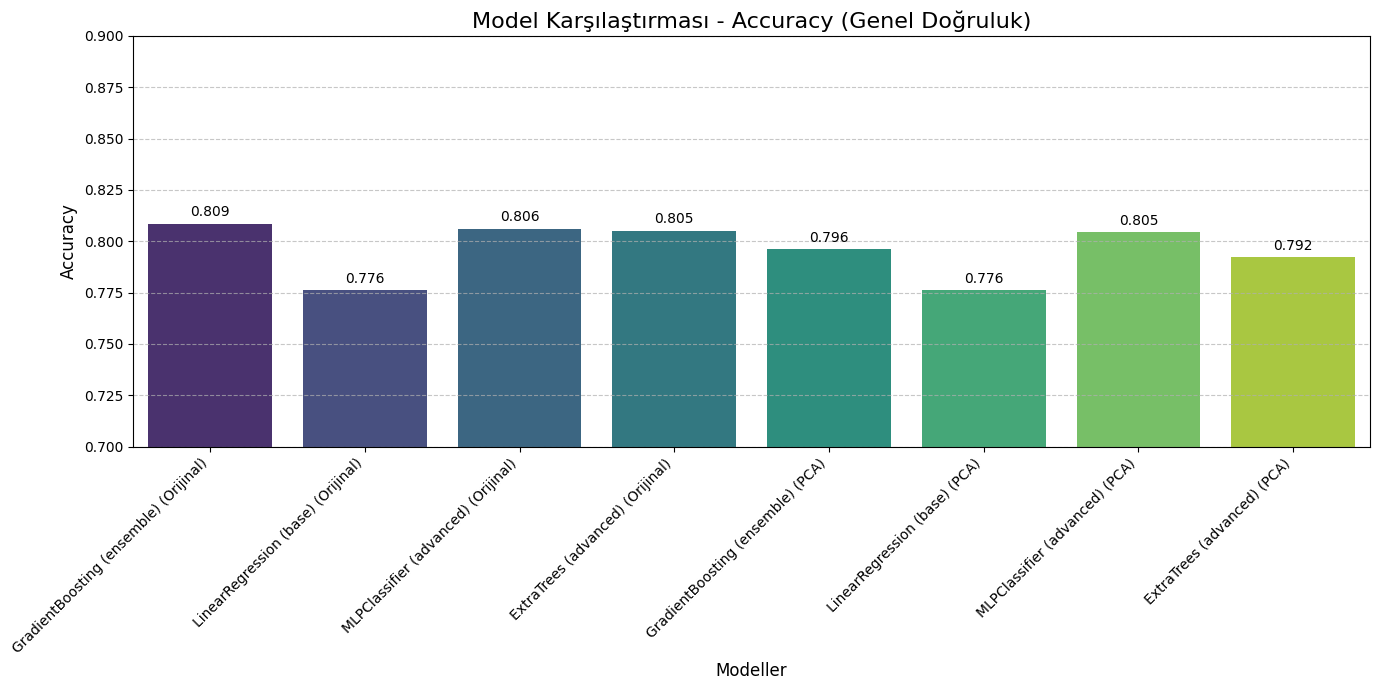

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik Boyutu
plt.figure(figsize=(14, 7))

# Accuracy verisi her satırda aynı olduğu için, sadece tekil modelleri alalım
# (Yani Grip Var/Yok satırlarını teke düşürelim ki grafik karışmasın)
# Not: Burada 'final_df' kullanıyoruz çünkü son kodda öyle isimlendirmiştik.
plot_data = final_df.drop_duplicates(subset=['Model'])

# Çizim
ax = sns.barplot(x='Model', y='Accuracy', data=plot_data, palette='viridis', hue='Model', legend=False)

plt.title('Model Karşılaştırması - Accuracy (Genel Doğruluk)', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Modeller', fontsize=12)
plt.xticks(rotation=45, ha='right') # İsimleri eğik yaz ki sığsın
plt.ylim(0.7, 0.9) # Grafiğin altını 0.7'den başlat ki farklar net görünsün (İsteğe bağlı)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Çubukların üzerine sayıları yazdırma (Okunabilirlik için)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

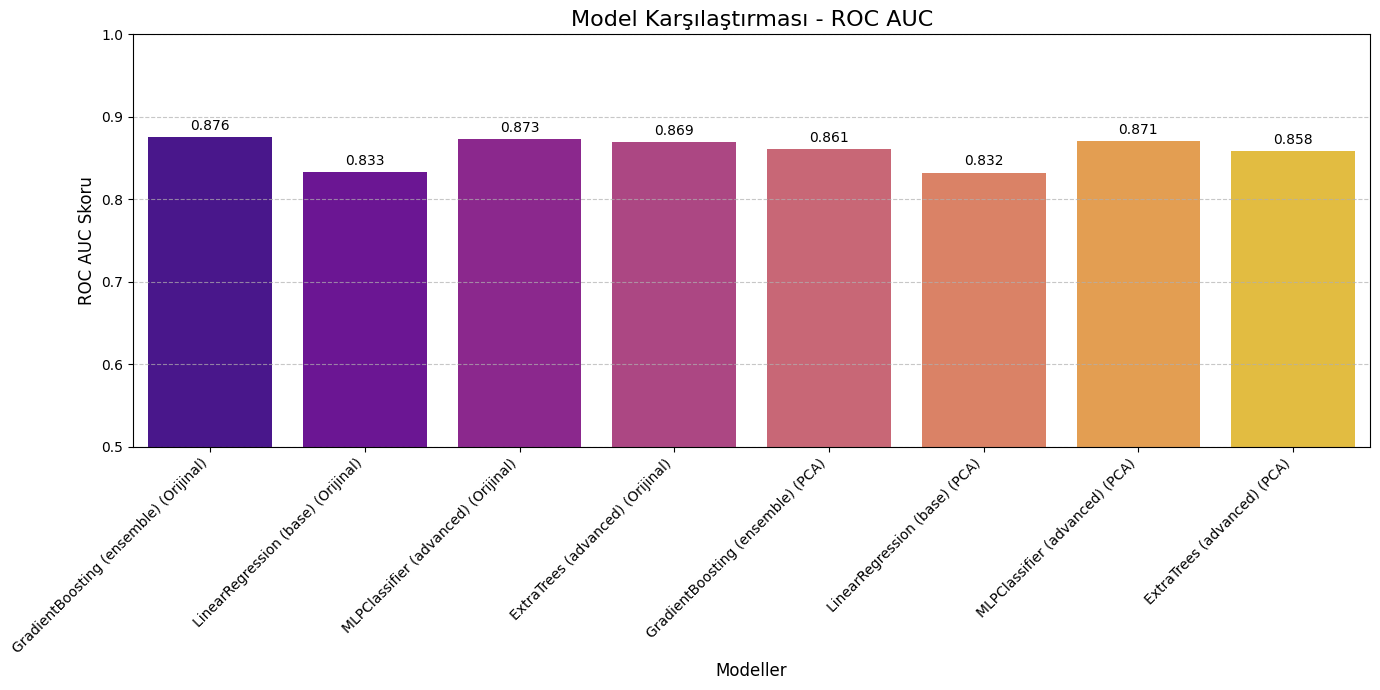

In [30]:
plot_data = final_df.drop_duplicates(subset=['Model'])

plt.figure(figsize=(14, 7))

ax = sns.barplot(x='Model', y='ROC AUC', data=plot_data, palette='plasma', hue='Model', legend=False)

plt.title('Model Karşılaştırması - ROC AUC', fontsize=16)
plt.ylabel('ROC AUC Skoru', fontsize=12)
plt.xlabel('Modeller', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Görsellik ayarları
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

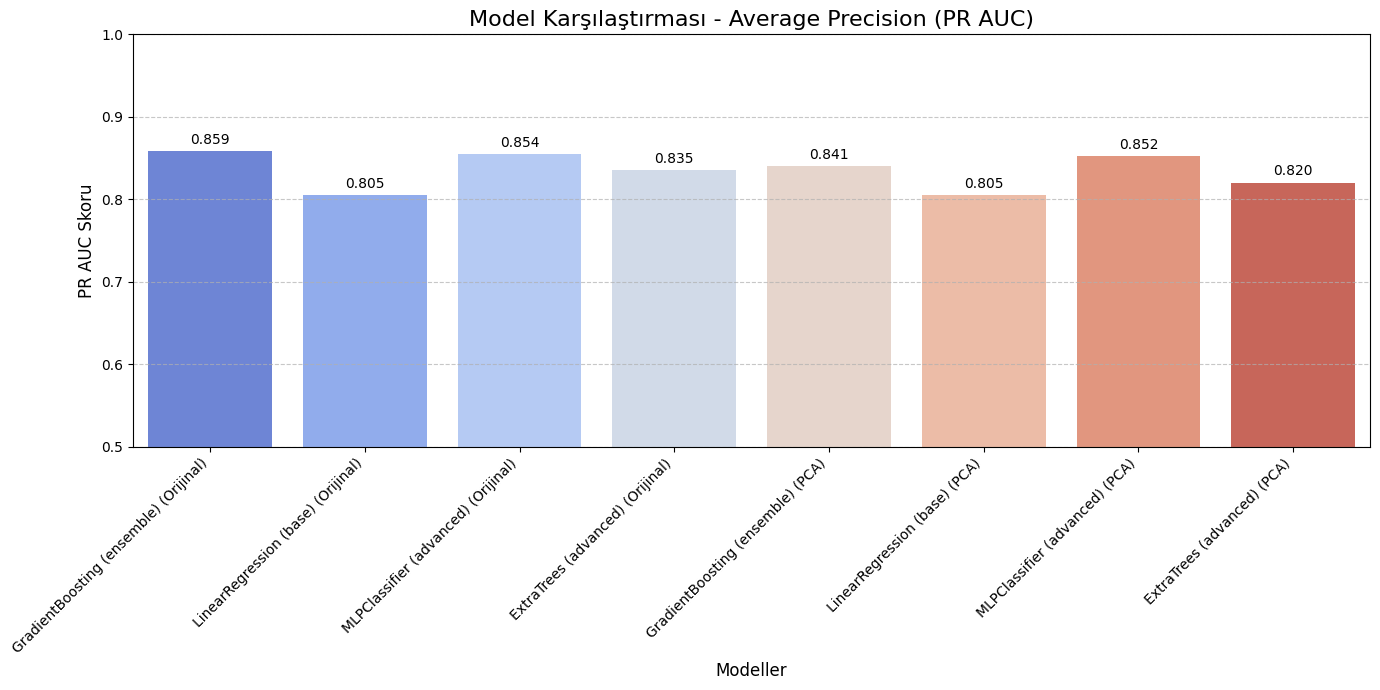

In [32]:
plot_data = final_df.drop_duplicates(subset=['Model'])

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='Model', y='PR AUC', data=plot_data, palette='coolwarm', hue='Model', legend=False)
plt.title('Model Karşılaştırması - Average Precision (PR AUC)', fontsize=16)
plt.ylabel('PR AUC Skoru', fontsize=12)
plt.xlabel('Modeller', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Çubukların üzerine sayıları yaz
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

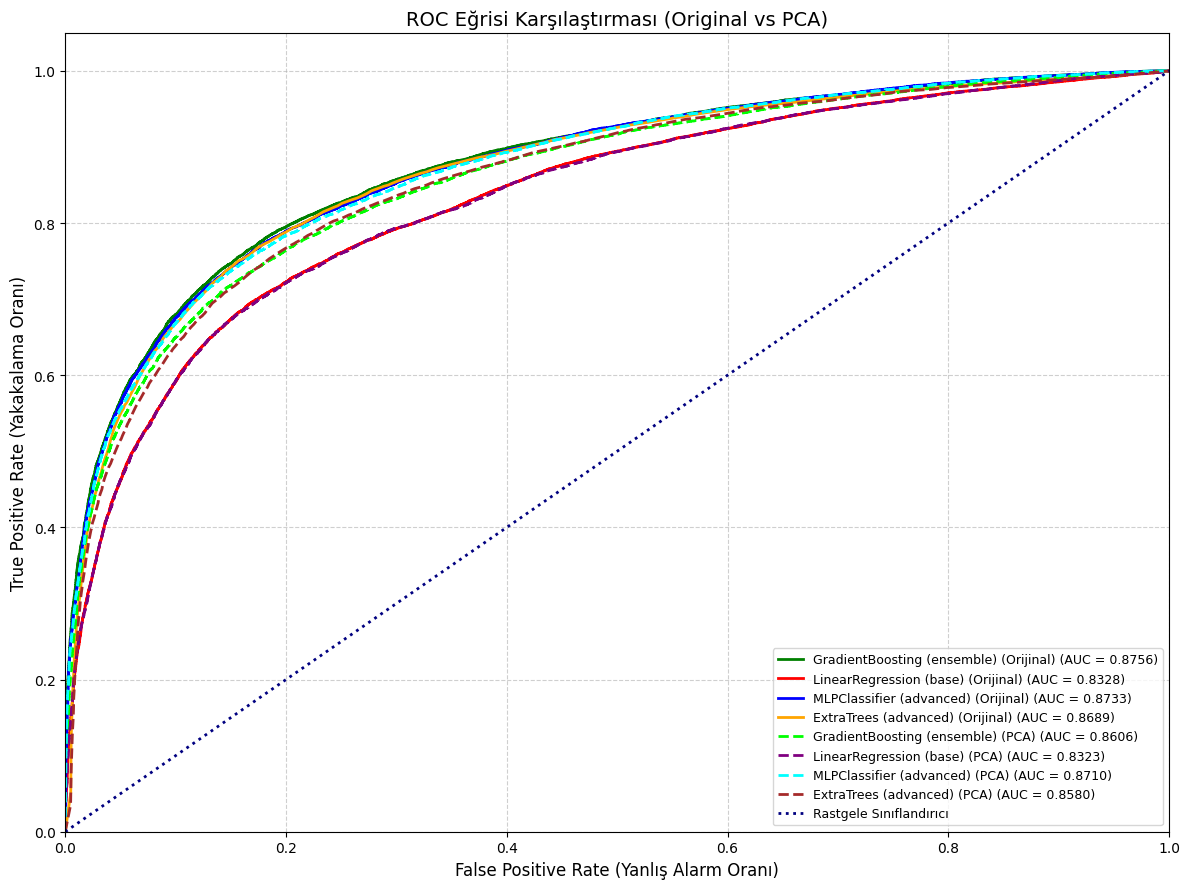

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --- 1. ROC HESAPLAMA KISMI ---
roc_curves = {}

# 'models' ve 'data_sets' hafızada tanımlı olmalı
for model_name, model in models.items():
    
    # Veri seti kontrolü
    if model_name in data_sets:
        _, X_test_current = data_sets[model_name]
    else:
        continue 
    
    # Olasılıkları Hesapla
    if "LinearRegression" in model_name:
        y_probs = np.clip(model.predict(X_test_current), 0, 1)
    else:
        y_probs = model.predict_proba(X_test_current)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    roc_curves[model_name] = (fpr, tpr, roc_auc)

# --- 2. GRAFİK ÇİZİMİ (RENKLENDİRİLMİŞ & AYRIŞTIRILMIŞ) ---
plt.figure(figsize=(12, 9))

# Renkleri manuel olarak belirleyelim ki karışmasın
colors = {
    # ORİJİNAL MODELLER (Koyu/Ana Renkler)
    'LinearRegression': 'red', 
    'GradientBoosting': 'green', 
    'MLPClassifier': 'blue',
    'ExtraTrees': 'orange',
    
    # PCA MODELLERİ (Farklı Tonlar)
    'LinearRegression_PCA': 'purple',  # Kırmızı yerine Mor
    'GradientBoosting_PCA': 'lime',    # Yeşil yerine Açık Yeşil
    'MLPClassifier_PCA': 'cyan',       # Mavi yerine Açık Mavi/Turkuaz
    'ExtraTrees_PCA': 'brown'          # Turuncu yerine Kahverengi
}

for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    # 1. Modelin ana ismini bul (Örn: GradientBoosting)
    base_name = model_name.split(' ')[0]
    
    # 2. Renk Seçimi: Eğer isimde "PCA" geçiyorsa özel rengini al
    if "PCA" in model_name:
        lookup_key = base_name + "_PCA" # Örn: GradientBoosting_PCA
        linestyle = '--' # PCA'ler kesikli çizgi olsun
    else:
        lookup_key = base_name # Örn: GradientBoosting
        linestyle = '-'  # Orijinaller düz çizgi olsun
        
    # Rengi sözlükten çek, bulamazsan siyah yap
    color = colors.get(lookup_key, 'black')
    
    # Çiz
    plt.plot(fpr, tpr, lw=2, color=color, linestyle=linestyle, 
             label=f'{model_name} (AUC = {roc_auc:.4f})')

# Referans Çizgisi
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', label='Rastgele Sınıflandırıcı')

# Ayarlar
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)', fontsize=12)
plt.ylabel('True Positive Rate (Yakakalama Oranı)', fontsize=12)
plt.title('ROC Eğrisi Karşılaştırması (Original vs PCA)', fontsize=14)
plt.legend(loc="lower right", fontsize=9) # Legend yazı boyutunu biraz küçülttük sığsın diye
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

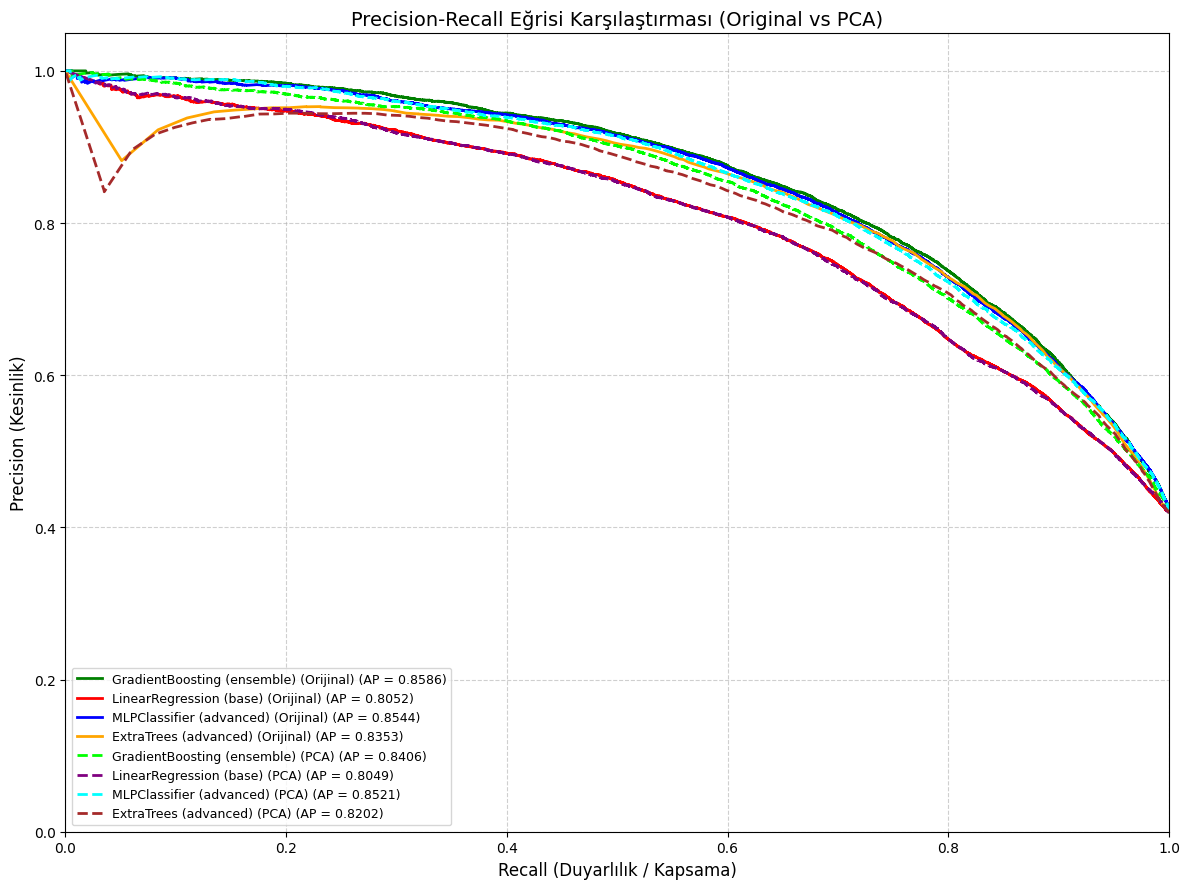

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PR VERİLERİNİ HESAPLAMA KISMI ---
pr_curves = {}

# 'models' ve 'data_sets' hafızada tanımlı olmalı
for model_name, model in models.items():
    
    # Veri seti kontrolü
    if model_name in data_sets:
        _, X_test_current = data_sets[model_name]
    else:
        continue 
    
    # Olasılıkları Hesapla
    if "LinearRegression" in model_name:
        y_probs = np.clip(model.predict(X_test_current), 0, 1)
    else:
        y_probs = model.predict_proba(X_test_current)[:, 1]
    
    # Precision, Recall ve AP (Average Precision) Hesapla
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    avg_precision = average_precision_score(y_test, y_probs)
    
    # Sözlüğe Kaydet
    pr_curves[model_name] = (recall, precision, avg_precision)

# --- 2. GRAFİK ÇİZİMİ (RENKLENDİRİLMİŞ & AYRIŞTIRILMIŞ) ---
plt.figure(figsize=(12, 9))

# Renkleri manuel olarak belirleyelim
colors = {
    # ORİJİNAL MODELLER (Koyu/Ana Renkler)
    'LinearRegression': 'red', 
    'GradientBoosting': 'green', 
    'MLPClassifier': 'blue',
    'ExtraTrees': 'orange',
    
    # PCA MODELLERİ (Farklı Tonlar)
    'LinearRegression_PCA': 'purple',  # Kırmızı -> Mor
    'GradientBoosting_PCA': 'lime',    # Yeşil -> Açık Yeşil
    'MLPClassifier_PCA': 'cyan',       # Mavi -> Turkuaz
    'ExtraTrees_PCA': 'brown'          # Turuncu -> Kahverengi
}

for model_name, (recall, precision, avg_precision) in pr_curves.items():
    # 1. Modelin ana ismini bul (Örn: GradientBoosting)
    base_name = model_name.split(' ')[0]
    
    # 2. Renk ve Çizgi Stili Seçimi
    if "PCA" in model_name:
        lookup_key = base_name + "_PCA" 
        linestyle = '--' # PCA'ler kesikli çizgi
    else:
        lookup_key = base_name 
        linestyle = '-'  # Orijinaller düz çizgi
        
    # Rengi sözlükten çek
    color = colors.get(lookup_key, 'black')
    
    # Çiz
    plt.plot(recall, precision, lw=2, color=color, linestyle=linestyle, 
             label=f'{model_name} (AP = {avg_precision:.4f})')

# Ayarlar
plt.xlabel('Recall (Duyarlılık / Kapsama)', fontsize=12)
plt.ylabel('Precision (Kesinlik)', fontsize=12)
plt.title('Precision-Recall Eğrisi Karşılaştırması (Original vs PCA)', fontsize=14)
plt.legend(loc="lower left", fontsize=9) # Sol alta aldık, genelde orada boşluk olur
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()